# Model related code
Made by: Tashyan Artyom, U2110268

### Imports and parameters

In [63]:
# Imports
import pickle
import re
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

from torch import tensor, optim
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer
from sklearn.feature_extraction.text import CountVectorizer

In [69]:
# Parameters and constants
MAX_LEN = 10000
learning_rate = 0.00001
epochs = 15
batch_size = 64
hidden_size = 64
hidden_size_2 = 10
dropout_coefficient = 0.3
train_factor = 0.6
test_factor = 0.2
valid_factor = 0.2
fresh_start = False

nltk.download('stopwords')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Selected device: {device}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sqdar\AppData\Roaming\nltk_data...


Selected device: cuda


[nltk_data]   Unzipping corpora\stopwords.zip.


### Data preparation

In [70]:
# Uploading our data from csv
df = pd.read_csv("./data/data.csv")
df["text"] = df["text"].fillna("")
df.head()

,Unnamed: 0,text,label
0,0,"Buck up, your troubles caused by small dimensi...",1
1,1,\nUpgrade your sex and pleasures with these te...,1
2,2,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1
3,3,Would anyone object to removing .so from this ...,0
4,4,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1


In [71]:
def preprocess_text(text: str) -> str:
    lower_text = text.lower()
    text_without_links = re.sub(r'http\S+|www\S+|https\S+', '', lower_text, flags=re.MULTILINE)
    plain_text = re.sub(r'[^a-zA-Z\s]', '', text_without_links)
    return plain_text

In [72]:
def tokenizer(text) -> list[str]:
    stemmer = PorterStemmer()
    tokens = re.findall(r'\b\w+\b', text)
    
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

In [74]:
# Dataset
class EmailDataset(Dataset):
    def __init__(self, email_df, vectorizer):
        self.emails = email_df["text"]
        self.labels = tensor(email_df["label"], dtype=torch.long)
        self.vectorizer = vectorizer
        
        csr_matrix = self.vectorizer.transform(self.emails)
        coo_matrix = csr_matrix.tocoo()
        indices = tensor([coo_matrix.row, coo_matrix.col])
        values = tensor(coo_matrix.data, dtype=torch.float32)
        self.vectorized_emails = torch.sparse_coo_tensor(indices, values, torch.Size(coo_matrix.shape)).to_dense()
        
    def __getitem__(self, index):
        email_vector = self.vectorized_emails[index]
        label = self.labels[index]
        return email_vector.to(device), label.to(device)
    
    def __len__(self):
        return len(self.emails)

In [75]:
# Vectorizer to convert texts of emails to vectors
if fresh_start:
    vectorizer = CountVectorizer(
        max_features=MAX_LEN,
        tokenizer=tokenizer,
        preprocessor=preprocess_text
    )
    vectorizer.fit(df["text"])
    
    with open("./vocab.pkl", "wb") as file:
        pickle.dump(vectorizer, file)
else:
    with open("./vocab.pkl", "rb") as file:
        vectorizer = pickle.load(file)

G:\SQD\Programming\anti-spam\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_features=10000,
                preprocessor=<function preprocess_text at 0x0000020B339DC040>,
                tokenizer=<function tokenizer at 0x0000020B81D4E7A0>)

In [111]:
vectorizer.vocabulary_["cock"]

np.int64(1598)

In [87]:
if fresh_start:
    ds = EmailDataset(df, vectorizer)
    
    with open("./train_data.pkl", "wb") as file:
        pickle.dump(df, file)
else:
    ds = pickle.load(open("./train_data.pkl", "rb"))

In [88]:
train_ds, valid_ds, test_ds = random_split(ds, [train_factor, valid_factor, test_factor])

In [89]:
# Dataloaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

### Model and training loop definition

In [90]:
# Function to assess accuracy of the model
@torch.no_grad
def accuracy(predictions: tensor, actuals: tensor) -> float:
    _, preds =torch.max(predictions, 1)
    preds
    accuracy = torch.sum(preds == actuals.view(-1))/x_batch.shape[0]
    return accuracy.item()

In [91]:
# Model
class PhishingDetectorModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.layers = nn.ModuleList([
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_coefficient),
            nn.Linear(hidden_size, hidden_size_2),
            nn.ReLU(),
            nn.Dropout(dropout_coefficient),
            nn.Linear(hidden_size_2, output_size),
        ])
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [92]:
model = PhishingDetectorModel(
    input_size=MAX_LEN,
    hidden_size=hidden_size, 
    output_size=2
).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

In [93]:
# Training loop
def fit(epochs, model, train_dl, valid_dl, loss_function, optimizer, t_losses, v_losses, t_accuracies, v_accuracies):
    for epoch in range(epochs):
        model.train()
        total_loss, total_acc, count = 0., 0., 0.
        for x_batch, y_batch in train_dl:
            optimizer.zero_grad()
            predictions = model(x_batch)
            loss = loss_function(predictions, y_batch.view(-1))
            batch_len = len(x_batch)
            count += batch_len
            total_loss += loss.item() * batch_len
            acc = accuracy(predictions, y_batch.view(-1))
            total_acc += acc * batch_len
            loss.backward()
            optimizer.step()
        t_losses.append(total_loss / count)
        t_accuracies.append(total_acc / count)
        
        model.eval()
        total_loss, total_acc, count = 0., 0., 0.
        for x_batch, y_batch in valid_dl:
            predictions = model(x_batch)
            loss = loss_function(predictions, y_batch.view(-1))
            batch_len = len(x_batch)
            count += batch_len
            total_loss += loss.item() * batch_len
            acc = accuracy(predictions, y_batch.view(-1))
            total_acc += acc * batch_len
        v_losses.append(total_loss / count)
        v_accuracies.append(total_acc / count)
        
        print(f"Epoch: {epoch}, Loss: {total_loss / count}, Accuracy: {total_acc / count}")
        

In [94]:
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

fit(
    epochs=epochs,
    model=model,
    loss_function=loss_function,
    optimizer=optimizer,
    train_dl=train_dl,
    valid_dl=valid_dl,
    t_losses=train_losses,
    v_losses=valid_losses,
    t_accuracies=valid_accuracies,
    v_accuracies=train_accuracies,
)

Epoch: 0, Loss: 0.5951816364140886, Accuracy: 0.6244056487314831
Epoch: 1, Loss: 0.45912985362045283, Accuracy: 0.8275540609569215
Epoch: 2, Loss: 0.3564084000072304, Accuracy: 0.9048500553379873
Epoch: 3, Loss: 0.2881417139565419, Accuracy: 0.9385178997105398
Epoch: 4, Loss: 0.2435662997564627, Accuracy: 0.9430130469947217
Epoch: 5, Loss: 0.21373156114420655, Accuracy: 0.9418493529712243
Epoch: 6, Loss: 0.19182794029132563, Accuracy: 0.9428087221181679
Epoch: 7, Loss: 0.17714023386348193, Accuracy: 0.9432173718712753
Epoch: 8, Loss: 0.16568203268354803, Accuracy: 0.9454989996594585
Epoch: 9, Loss: 0.15636765566144994, Accuracy: 0.9474400859867189
Epoch: 10, Loss: 0.14980680735345067, Accuracy: 0.9495173888983484
Epoch: 11, Loss: 0.14306928509547887, Accuracy: 0.9513222586412395
Epoch: 12, Loss: 0.1373559495263219, Accuracy: 0.9531952366763153
Epoch: 13, Loss: 0.1336038875230711, Accuracy: 0.9541146986208071
Epoch: 14, Loss: 0.13026649120128805, Accuracy: 0.9556130810488677


### Data vizualization

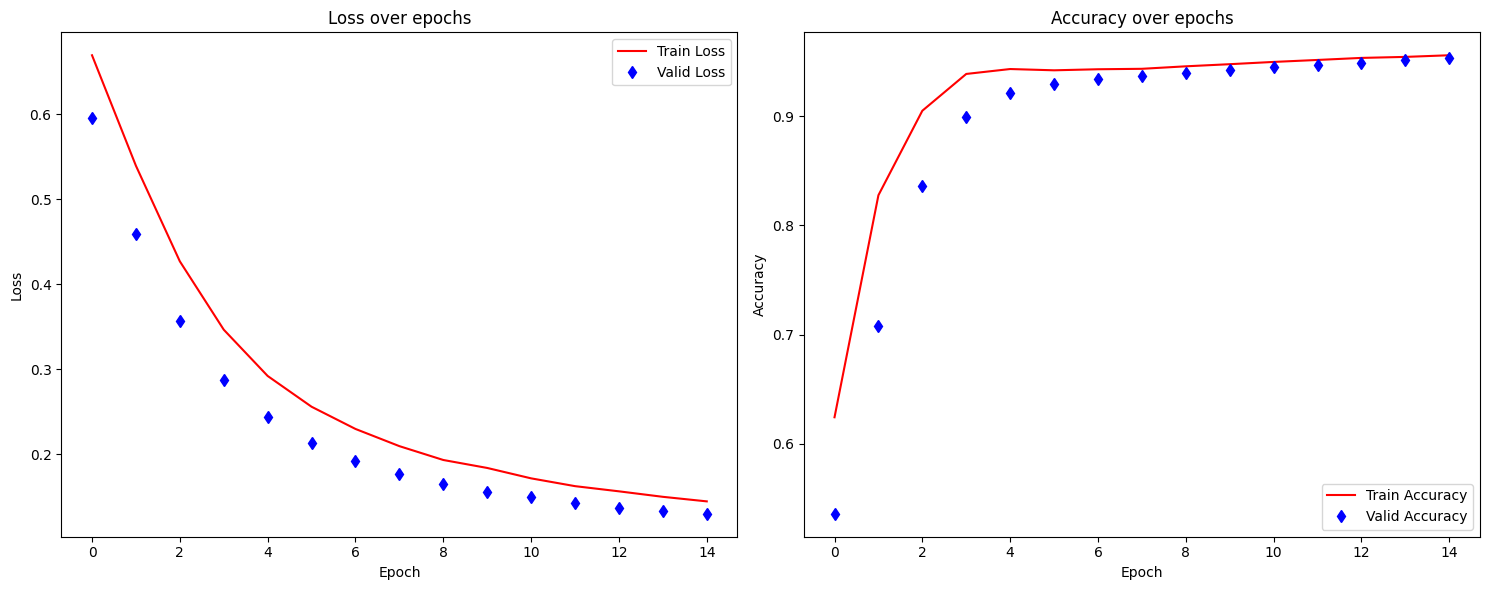

In [113]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax[0].plot(train_losses, "r", label="Train Loss")
ax[0].plot(valid_losses, "bd", label="Valid Loss")
ax[0].set_title("Loss over epochs")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[0].set_ylabel("Loss")

ax[1].plot(train_accuracies, "r", label="Train Accuracy")
ax[1].plot(valid_accuracies, "bd", label="Valid Accuracy")
ax[1].set_title("Accuracy over epochs")
ax[1].set_xlabel("Epoch")
ax[1].legend()
ax[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [ ]:
x_batch, y_batch = next(iter(test_dl))
x_batch[1], y_batch[1]

In [ ]:
x_batch.shape, y_batch.shape

In [ ]:
predictions = model(x_batch)
probabilities = torch.sigmoid(predictions)
probabilities = torch.softmax(predictions, dim=1)
acc = accuracy(probabilities[:, 1], y_batch.view(-1))

In [ ]:
_, preds =torch.max(predictions, 1)
preds

In [ ]:
torch.sum(preds == y_batch.view(-1))/x_batch.shape[0]

In [ ]:
accuracy(predictions, y_batch)

### Interface to call the model prediction

In [114]:
def predict_email(email, model, vectorizer, device, top_n=5):
    model.eval()
    
    email_csrmatrix = vectorizer.transform([email])
    email_coomatrix = email_csrmatrix.tocoo()
    indices = tensor([email_coomatrix.row, email_coomatrix.col]).to(device)
    values = tensor(email_coomatrix.data, dtype=torch.float32).to(device)
    email_tensor = torch.sparse_coo_tensor(indices, values, torch.Size(email_coomatrix.shape)).to_dense().to(device)
    
    with torch.no_grad():
        outputs = model(email_tensor)
        _, prediction = torch.max(outputs, 1)
        
        first_layer_weights = model.layers[0].weight.data.cpu().numpy()
        suspicious_weights = first_layer_weights[1]
        
        word_importance = email_tensor[0].cpu() * suspicious_weights
        important_words_indices = np.argsort(word_importance)[-top_n:]
        
        important_words = [vectorizer.get_feature_names_out()[i] for i in important_words_indices]
        important_scores = [word_importance[i] for i in important_words_indices]
        
        important_scores = tensor(important_scores).softmax(dim=0)
        important_scores = [score * 100 for score in important_scores]
    
    return prediction.item(), torch.softmax(outputs, dim=1).cpu().numpy(), list(zip(important_words, important_scores))

In [116]:
sus_mail = """Dear [Your Name],

We hope you're doing well. Your monthly bank statement for September 2024 is now available. You can view and download your statement by logging into your account.

To access your statement:

Go to our official website: www.yourbank.com.
Log in with your credentials.
Navigate to the "Statements" section under your account dashboard.
If you have any questions or need assistance, please feel free to contact our customer support team.

Thank you for banking with us!

Best regards,
Customer Service Team
YourBank Inc.
Contact Us: 1-800-123-4567
www.yourbank.com"""

ok_mail = """Hey [Your Name],

I hope you're doing well! It's been a while since we last caught up, and I was thinking it would be great to hang out sometime soon. How about grabbing coffee this weekend?

Let me know if you're free, or if another time works better for you. I’d love to hear what you’ve been up to lately and share some updates on my end too!

Looking forward to seeing you soon.

Take care,
[Friend's Name]

P.S. If you're busy this weekend, no worries—we can plan for another time! :)"""
 
sus, confidency, words = predict_email(ok_mail, model, vectorizer, device, top_n=10)

print(f"Sus: {sus}, Confidence: {confidency.max() * 100:.2f}, Words: {words}")

Sus: 0, Confidence: 89.02, Words: [('would', tensor(9.9380)), ('know', tensor(9.9423)), ('id', tensor(9.9506)), ('ps', tensor(9.9692)), ('hey', tensor(9.9800)), ('weekend', tensor(10.0182)), ('think', tensor(10.0223)), ('time', tensor(10.0426)), ('forward', tensor(10.0477)), ('your', tensor(10.0891))]


C:\Users\sqdar\AppData\Local\Temp\ipykernel_6972\1932624220.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  word_importance = email_tensor[0].cpu() * suspicious_weights


In [ ]:
losses, accuracies = [], []
total_loss, total_acc, count = 0., 0., 0.
 
for x_batch, y_batch in test_dl:
    predictions = model(x_batch)
    loss = loss_function(predictions, y_batch.view(-1))
    count += len(x_batch)
    total_loss += loss.item()
    acc = accuracy(predictions, y_batch)
    total_acc += acc * len(x_batch)
losses.append(total_loss / count)
accuracies.append(total_acc / count)

print(f"Loss: {total_loss / count}, Accuracy: {total_acc / count}")